# Imports

In [153]:
import numpy as np
import pandas as pd
import pandas as pd
import seaborn as sns

# Data Loading & Preprocessing

In [155]:
def load_and_preprocess(path):
    df = pd.read_csv(path)
    y = (df['diagnosis'] == 'M').astype(int).values
    X = df.drop(columns=['id','diagnosis'], errors='ignore').values.astype(float)
    X = np.nan_to_num(X, nan=0.0, posinf=0.0, neginf=0.0)

    # Standardization  
    mean = X.mean(axis=0)
    std = X.std(axis=0)
    std[std == 0] = 1
    X = (X - mean) / std

    return X, y

# Load dataset
X, y = load_and_preprocess("breast_cancer.csv")
print("Data shape:", X.shape, "Labels shape:", y.shape)

Data shape: (569, 31) Labels shape: (569,)


# PCA Implementation

In [157]:
class PCA:
    def __init__(self, n_components):
        self.n = n_components

    def fit(self, X):
        cov = np.cov(X, rowvar=False)
        vals, vecs = np.linalg.eigh(cov)
        idx = np.argsort(vals)[::-1]
        self.vals = vals[idx]
        self.vecs = vecs[:, idx]
        self.components = self.vecs[:, :self.n]
        return self

    def transform(self, X):
        return X @ self.components

    def inverse_transform(self, Z):
        return Z @ self.components.T

    def reconstruction_error(self, X):
        Z = self.transform(X)
        X_hat = self.inverse_transform(Z)
        return np.mean((X - X_hat) ** 2)


# K-Means Implementation

In [159]:
class KMeans:
    def __init__(self, k, iters=100, init='kmeans++'):
        self.k = k
        self.iters = iters
        self.init = init

    def _init_centroids(self,X):
        n = X.shape[0]
        if self.init=='random':
            return X[np.random.choice(n,self.k,replace=False)]
            
        elif self.init=='kmeans++':
            centroids = [X[np.random.randint(0,n)]]
            for _ in range(1,self.k):
                dist = np.min([np.sum((X-c)**2,axis=1) for c in centroids],axis=0)
                
                # to avoid NaN
                if np.all(dist==0) or np.isnan(dist).any():
                    prob = np.ones(n)/n
                    
                else:
                    prob = dist/dist.sum()
                centroids.append(X[np.random.choice(n,p=prob)])
                
            return np.array(centroids)

    def fit(self,X):
        n = X.shape[0]
        self.centroids = self._init_centroids(X)
        self.inertia_history = []

        for _ in range(self.iters):
            dists = np.linalg.norm(X[:,None]-self.centroids,axis=2)
            self.labels = np.argmin(dists,axis=1)

            new_centroids = np.array([X[self.labels==i].mean(axis=0) for i in range(self.k)])
            if np.allclose(self.centroids,new_centroids, atol=1e-6):
                break
            self.centroids = new_centroids

        self.inertia = np.sum((X-self.centroids[self.labels])**2)
        return self


# Validation Metrics

In [161]:
def silhouette_score(X, labels):
    n = len(X)
    unique = np.unique(labels)
    sil = []

    for i in range(n):
        same = labels == labels[i]
        a = np.mean(np.linalg.norm(X[i] - X[same], axis=1))

        b = np.min([
            np.mean(np.linalg.norm(X[i] - X[labels == l], axis=1))
            for l in unique if l != labels[i]
        ])

        sil.append((b - a) / max(a, b))
    return np.mean(sil)


def davies_bouldin(X, labels):
    clusters = np.unique(labels)
    centroids = np.array([X[labels == c].mean(axis=0) for c in clusters])
    S = np.array([
        np.mean(np.linalg.norm(X[labels == c] - centroids[i], axis=1))
        for i, c in enumerate(clusters)
    ])

    db = []
    for i in range(len(clusters)):
        ratios = []
        for j in range(len(clusters)):
            if i != j:
                ratios.append((S[i] + S[j]) /
                              np.linalg.norm(centroids[i] - centroids[j]))
        db.append(max(ratios))
    return np.mean(db)


def calinski_harabasz(X, labels):
    n = len(X)
    clusters = np.unique(labels)
    overall_mean = X.mean(axis=0)

    B, W = 0, 0
    for c in clusters:
        Xc = X[labels == c]
        mean_c = Xc.mean(axis=0)
        B += len(Xc) * np.sum((mean_c - overall_mean) ** 2)
        W += np.sum((Xc - mean_c) ** 2)

    return (B / (len(clusters) - 1)) / (W / (n - len(clusters)))


def purity_score(y_true, y_pred):
    total = 0
    for c in np.unique(y_pred):
        _, counts = np.unique(y_true[y_pred == c], return_counts=True)
        total += counts.max()
    return total / len(y_true)

# Experiment 3 – K-Means after PCA


Dims= 2 | Inertia= 5332.98 | ReconErr=0.3557 | ExplVar=0.6324 | Sil=0.5100 | DB=0.8441 | CH=580.78 | Purity=0.9086


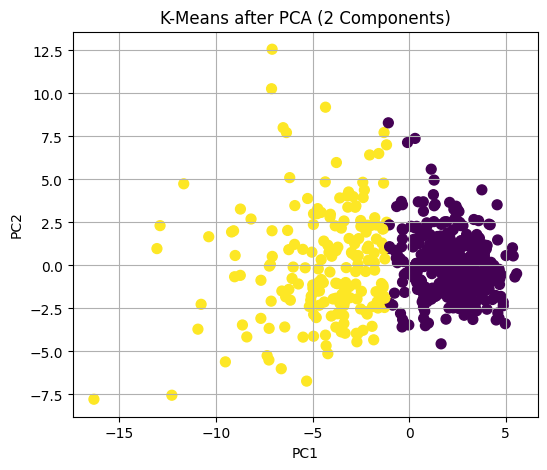

Dims= 5 | Inertia= 8991.83 | ReconErr=0.1477 | ExplVar=0.8473 | Sil=0.3955 | DB=1.1409 | CH=345.07 | Purity=0.9104


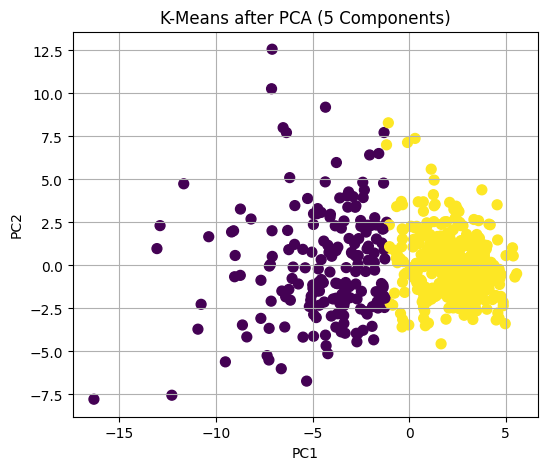

Dims=10 | Inertia=10770.55 | ReconErr=0.0469 | ExplVar=0.9516 | Sil=0.3588 | DB=1.2679 | CH=288.10 | Purity=0.9051


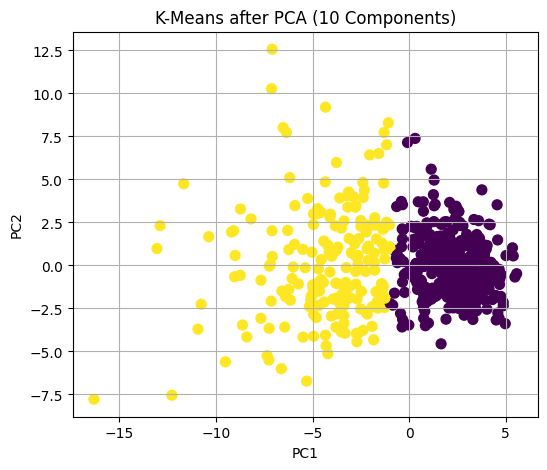

Dims=15 | Inertia=11365.60 | ReconErr=0.0131 | ExplVar=0.9865 | Sil=0.3505 | DB=1.2948 | CH=273.07 | Purity=0.9121


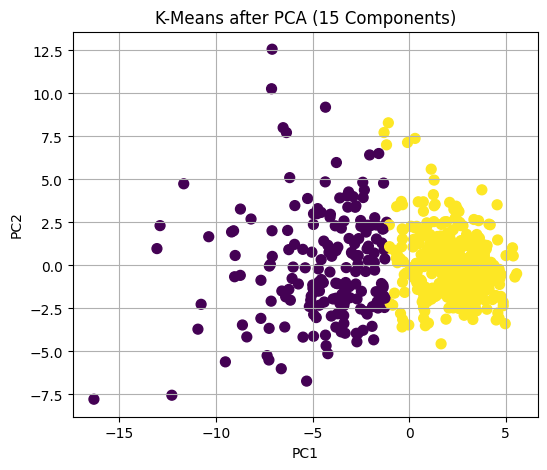

Dims=20 | Inertia=11520.17 | ReconErr=0.0043 | ExplVar=0.9956 | Sil=0.3463 | DB=1.3159 | CH=269.43 | Purity=0.9069


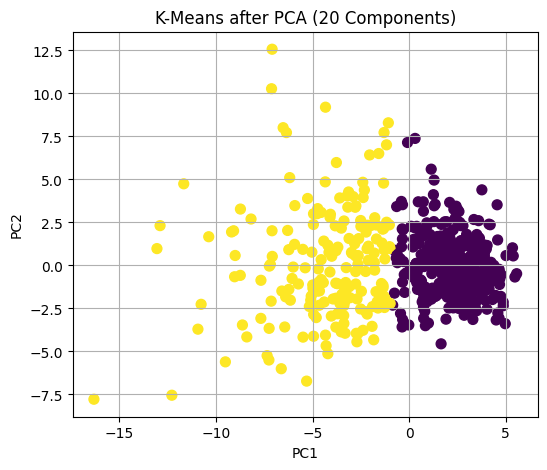

Dim | Inertia | Recon Error | Explained Var | Silhouette | DB | CH | Purity
  2 |  5332.98 |    242.0399 |        0.6324 |     0.5100 | 0.8441 | 580.78 | 0.9086115992970123
  5 |  8991.83 |     11.1648 |        0.8473 |     0.3955 | 1.1409 | 345.07 | 0.9103690685413005
 10 | 10770.55 |      0.0420 |        0.9516 |     0.3588 | 1.2679 | 288.10 | 0.9050966608084359
 15 | 11365.60 |      0.0029 |        0.9865 |     0.3505 | 1.2948 | 273.07 | 0.9121265377855887
 20 | 11520.17 |      0.0005 |        0.9956 |     0.3463 | 1.3159 | 269.43 | 0.9068541300527241


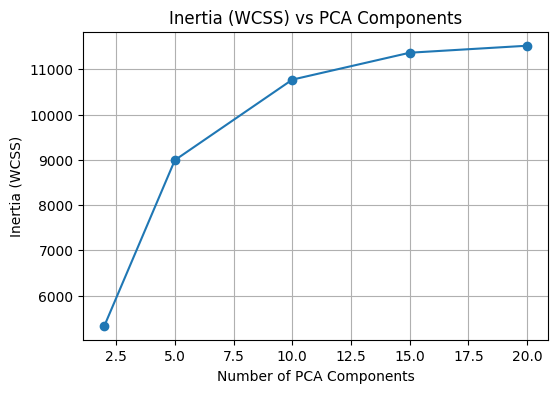

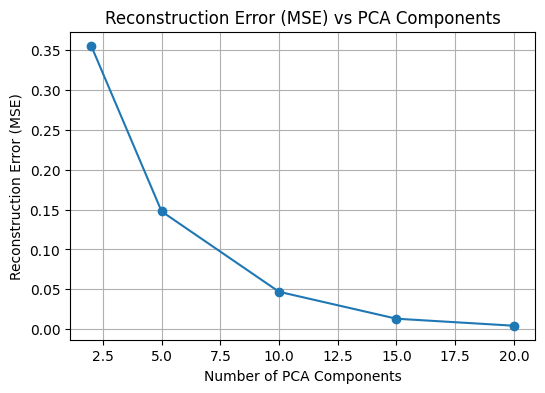

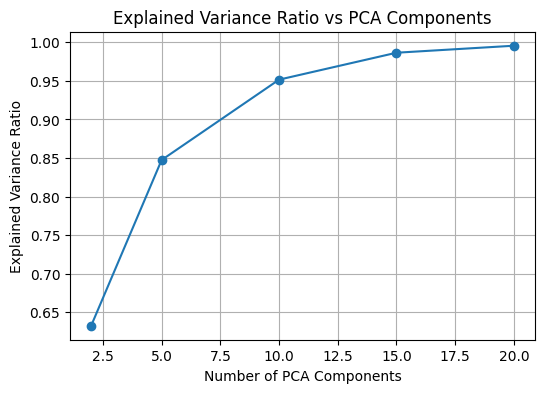

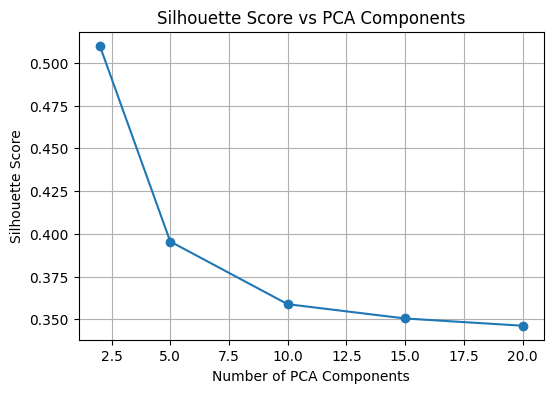

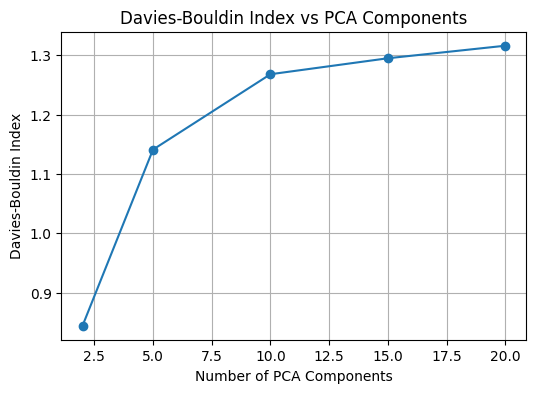

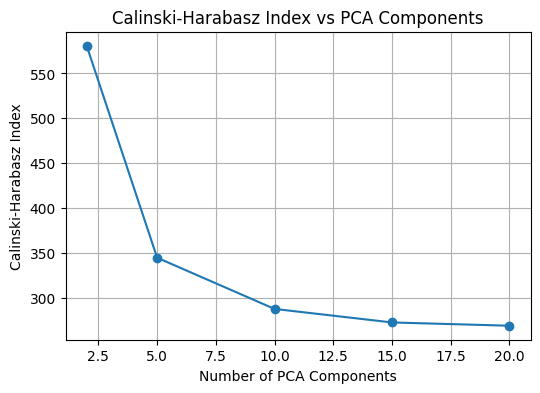

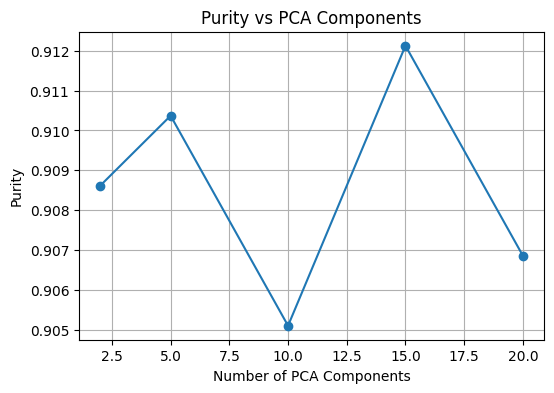

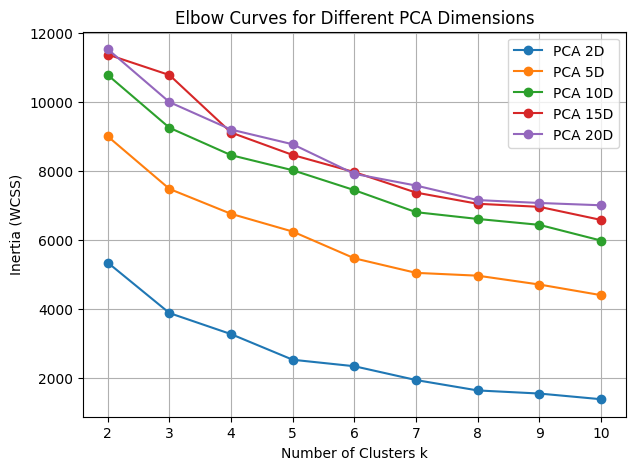

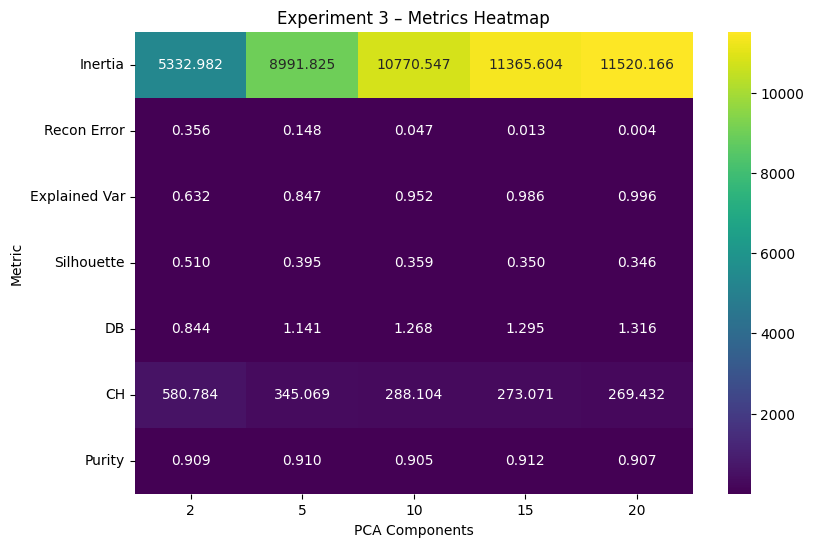

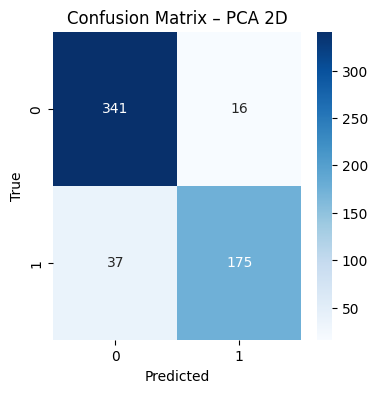

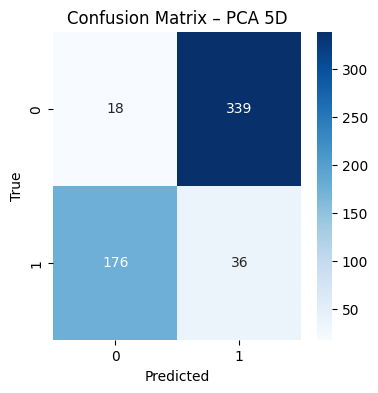

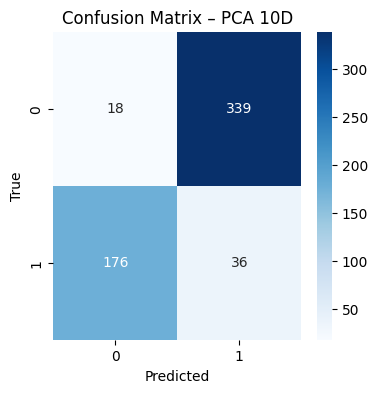

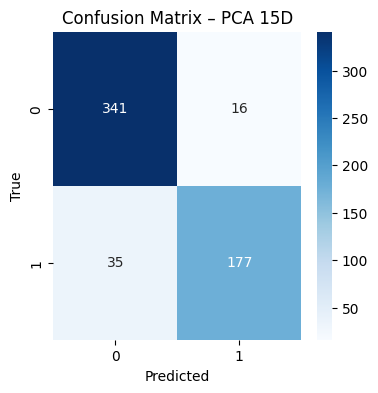

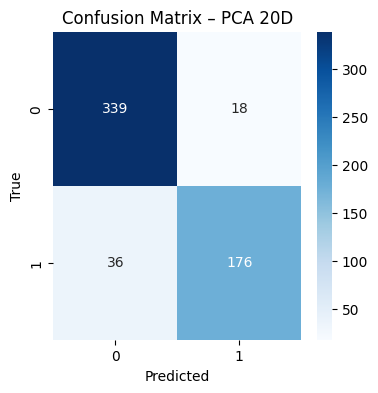

In [163]:
dims_list = [2, 5, 10, 15, 20]

inertia_list = []
recon_list = []
explained_var_list = []
silhouette_list = []
db_list = []
ch_list = []
purity_list = []

# Run experiment

for d in dims_list:
    pca = PCA(d).fit(X)
    Z = pca.transform(X)

    km = KMeans(2, iters=50, init='kmeans++').fit(Z)

    inertia_list.append(km.inertia)
    recon_list.append(pca.reconstruction_error(X))
    explained_var_list.append(np.sum(pca.vals[:d]) / np.sum(pca.vals))
    silhouette_list.append(silhouette_score(Z, km.labels))
    db_list.append(davies_bouldin(Z, km.labels))
    ch_list.append(calinski_harabasz(Z, km.labels))
    purity_list.append(purity_score(y, km.labels))

    print(
        f"Dims={d:2d} | "
        f"Inertia={km.inertia:8.2f} | "
        f"ReconErr={recon_list[-1]:.4f} | "
        f"ExplVar={explained_var_list[-1]:.4f} | "
        f"Sil={silhouette_list[-1]:.4f} | "
        f"DB={db_list[-1]:.4f} | "
        f"CH={ch_list[-1]:.2f} | "
        f"Purity={purity_list[-1]:.4f}"
    )

    # 2D Scatter (always first 2 PCs)
    plt.figure(figsize=(6,5))
    plt.scatter(Z[:,0], Z[:,1], c=km.labels, cmap='viridis', s=50)
    plt.title(f"K-Means after PCA ({d} Components)")
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.grid(True)
    plt.show()

# ==== Report Results ====
print("Dim | Inertia | Recon Error | Explained Var | Silhouette | DB | CH | Purity")
for i, d in enumerate(dims_list):
    purity_val = purity_list[i] if purity_list else '-'
    print(f"{d:>3} | {inertia_list[i]:>8.2f} | {recon_error_list[i]:>11.4f} | "
          f"{explained_var_list[i]:>13.4f} | {silhouette_list[i]:>10.4f} | "
          f"{db_list[i]:>5.4f} | {ch_list[i]:>5.2f} | {purity_val}")

# Plot each metric separately
metrics = {
    "Inertia (WCSS)": inertia_list,
    "Reconstruction Error (MSE)": recon_list,
    "Explained Variance Ratio": explained_var_list,
    "Silhouette Score": silhouette_list,
    "Davies-Bouldin Index": db_list,
    "Calinski-Harabasz Index": ch_list,
    "Purity": purity_list
}

for name, values in metrics.items():
    plt.figure(figsize=(6,4))
    plt.plot(dims_list, values, marker='o')
    plt.xlabel("Number of PCA Components")
    plt.ylabel(name)
    plt.title(f"{name} vs PCA Components")
    plt.grid(True)
    plt.show()


# Elbow Curve (WCSS vs k)
k_values = range(2, 11)

plt.figure(figsize=(7,5))
for d in dims_list:
    pca = PCA(d).fit(X)
    Z = pca.transform(X)

    inertia_k = []
    for k in k_values:
        km = KMeans(k, iters=100, init='kmeans++').fit(Z)
        inertia_k.append(km.inertia)

    plt.plot(k_values, inertia_k, marker='o', label=f'PCA {d}D')

plt.xlabel("Number of Clusters k")
plt.ylabel("Inertia (WCSS)")
plt.title("Elbow Curves for Different PCA Dimensions")
plt.legend()
plt.grid(True)
plt.show()


# Heatmap of metrics
metrics_df = pd.DataFrame({
    "Inertia": inertia_list,
    "Recon Error": recon_list,
    "Explained Var": explained_var_list,
    "Silhouette": silhouette_list,
    "DB": db_list,
    "CH": ch_list,
    "Purity": purity_list
}, index=dims_list)

plt.figure(figsize=(9,6))
sns.heatmap(metrics_df.T, annot=True, fmt=".3f", cmap="viridis")
plt.title("Experiment 3 – Metrics Heatmap")
plt.xlabel("PCA Components")
plt.ylabel("Metric")
plt.show()


# Confusion Matrices
from sklearn.metrics import confusion_matrix

for d in dims_list:
    pca = PCA(d).fit(X)
    Z = pca.transform(X)
    km = KMeans(2, iters=50, init='kmeans++').fit(Z)

    cm = confusion_matrix(y, km.labels)

    plt.figure(figsize=(4,4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title(f"Confusion Matrix – PCA {d}D")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()
